# Demo:  Document Clustering and Latent Semantic Analysis

An important application of clustering is for sorting documents into groups.  In this demo, we will illustrate how to use the k-means algorithms for this task.  This example is taken mostly from one of the [sklearn examples](http://scikit-learn.org/stable/auto_examples/text/document_clustering.html).

Through the demo, you will learn how to:
* Represent a corpus as a set of strings
* Build a vocabulary from a corpus
* Compute the TF-IDF scores for the documents in the corpus based on the vocabulary
* Run k-means to automatically discover document clusters
* Display key terms in each document cluster
* Perform an LSA on a corpus with a sparse SVD.

## Loading the Data

First, we load the standard packages along with a number of `sklearn` sub-packages for text processing.

In [38]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import sys
from time import time

import numpy as np

The [UseNet newsgroups](https://en.wikipedia.org/wiki/Usenet_newsgroup) were popular 20 years ago as online forums for discussing various issues.  Although they are not used much today for topic discussions, the posts from that era are still widely-used in machine learning classes for demonstrating various text processing methods.  Due to their wide use, the `sklearn` package has a built-in routine `fetch_20newsgroups` for extracting the newsgroup examples.  The code below can be used to get a subset of categories or all categories.

In [88]:
use_all_categories = True
if use_all_categories:
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

print("Loading 20 newsgroups dataset for selected categories")
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

Loading 20 newsgroups dataset for selected categories


We print out the categories and the number of documents in each category.  We see the `dataset` has two key fields:

* `dataset.target_names`:  The names of the categories
* `dataset.target`:  The index of the category for each post

In [90]:
categories = dataset.target_names
labels = dataset.target
ncat = len(categories)
for i in range(ncat):
    cnt = np.sum(labels == i)
    print('%-30s: %d ' % (categories[i], cnt))

alt.atheism                   : 799 
comp.graphics                 : 973 
comp.os.ms-windows.misc       : 985 
comp.sys.ibm.pc.hardware      : 982 
comp.sys.mac.hardware         : 963 
comp.windows.x                : 988 
misc.forsale                  : 975 
rec.autos                     : 990 
rec.motorcycles               : 996 
rec.sport.baseball            : 994 
rec.sport.hockey              : 999 
sci.crypt                     : 991 
sci.electronics               : 984 
sci.med                       : 990 
sci.space                     : 987 
soc.religion.christian        : 997 
talk.politics.guns            : 910 
talk.politics.mideast         : 940 
talk.politics.misc            : 775 
talk.religion.misc            : 628 


The data is in the `data` field of `dataset`.  Each entry `dataset.data[i]` is a string corresponding to the post to the newsgroup.  We can print an example as follows.

In [91]:
doc_ind = 20  # Index of an example document
data_ex = dataset.data[doc_ind]
cat_ex  = dataset.target_names[labels[doc_ind]]
print('Post from {0:s}'.format(cat_ex))
print()
print(data_ex)

Post from rec.autos

From: jackw@boi.hp.com (jack wood)
Subject: Re: Chevy/GMC 4x4 Fullsize Pickups, Opinions?
Distribution: na
Organization: Hewlett-Packard / Boise, Idaho
X-Newsreader: TIN [version 1.1.4 PL6]
Lines: 41

Dick Grady (grady@world.std.com) wrote:
: 
: I am considering buying a 1993 Chevy or GMC 4x4 full-size pickup with
: the extended cab.  Any opinions about these vehicles?  Have there been
: any significant problems?
: 
: -- 
: Dick Grady           Salem, NH,  USA            grady@world.std.com
: So many newsgroups, so little time!


I bought a brand new 1992 Chevrolet K2500 HD 4x4 extended cab last
May.  It has had many, many problems.  See my earler post that describes
the situation.  I went to BBB arbitration, and they ruled that Chevrolet
must buy it back from me.  If you do get one, stay away from the 5 speed
manual with the deep low first gear.  They have put three of them in my
truck so far.  After about 1,500 miles, overdrive either starts
rattling or hissing l

## Computing TF-IDF features

Documents are natively text.  To apply most machine learning algorithms, we need to convert the documents to vectors.  One popular method is the so-called TF-IDF score.  First, we select a set of words in the corpus.  Each word is sometimes called a *token*.  For each token `n` and document `i`, we then compute the data matrix:
      
    X[n,i] = TF-IDF score of word i in document n
           = term freq[n,i] * inverse doc frequency[i]
           
where

    term freq[n,i]  = (#occurances of word i in doc n)/(#words in doc n)  
    inverse doc freq[i] = log(#docs in corpus/#docs with word i)
        
In the data matrix `X`, each document `n` is represented by a vector `X[n,:]`.

The data matrix `X` can be computed by a *vectorizer*.  Writing an efficient vectorizer is somewhat time-consuming.  Luckily, `sklearn` has very good routines to compute the TF-IDF representations of a corpus.  We first create a `TfidfVectorizer` object:

In [92]:
vectorizer = TfidfVectorizer( 
                max_df=0.5, # max doc freq (as a fraction) of any word to include in the vocabulary
                min_df=2,   # min doc freq (as doc counts) of any word to include in the vocabulary
                max_features=10000,           # max number of words in the vocabulary
                stop_words='english',         # remove English stopwords
                use_idf=True )        # use IDF scores

Then, we create the data matrix from the dataset.

In [93]:
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
X = vectorizer.fit_transform(dataset.data)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)

Extracting features from the training dataset using a sparse vectorizer
done in 3.737130s
n_samples: 18846, n_features: 10000


We can display the terms with the highest TF-IDF scores in a post as follows.

In [95]:
doc_ind = 20  # Index of an example document
xi = X[doc_ind,:].todense()
term_ind = np.fliplr(xi.argsort())
xi_sort = xi[0,term_ind]
terms = vectorizer.get_feature_names()

for i in range(30):
    term = terms[term_ind[0,i]]
    tfidf = xi[0,term_ind[0,i]]
    print('{0:20s} {1:f} '.format(term, tfidf))

grady                0.352524 
truck                0.217618 
gear                 0.216398 
hd                   0.192578 
boi                  0.169038 
chevy                0.166363 
rpm                  0.163060 
350                  0.147700 
dick                 0.143673 
duty                 0.141442 
paint                0.137826 
extended             0.134956 
brand                0.129220 
std                  0.127186 
fix                  0.126137 
500                  0.115667 
attempt              0.115309 
bought               0.110747 
light                0.105704 
hp                   0.101480 
speed                0.100635 
buy                  0.094978 
com                  0.088686 
problems             0.088631 
salem                0.088521 
opinions             0.088382 
rail                 0.086027 
embedded             0.084239 
characteristic       0.083437 
far                  0.082767 


## Run k-Means

We now run k-means on the TF-IDF vectors to try  to automatically detect clusters.  First, we construct a `kMeans` object to perform the clustering.

In [96]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1,
                verbose=True)

Then, we run the k-means clustering.  This will run through several iterations.

In [97]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(max_iter=100, n_clusters=4, n_init=1, verbose=True)
Initialization complete
Iteration 0, inertia 36308.55050753375
Iteration 1, inertia 18483.78491841037
Iteration 2, inertia 18449.502064743752
Iteration 3, inertia 18435.418734316725
Iteration 4, inertia 18425.497261784905
Iteration 5, inertia 18421.03470869525
Iteration 6, inertia 18418.94116476523
Iteration 7, inertia 18417.230428206916
Iteration 8, inertia 18415.384950171392
Iteration 9, inertia 18413.987962558203
Iteration 10, inertia 18412.99329233192
Iteration 11, inertia 18412.171536205227
Iteration 12, inertia 18411.60837661232
Iteration 13, inertia 18411.225307704204
Iteration 14, inertia 18410.892197952897
Iteration 15, inertia 18410.599707570695
Iteration 16, inertia 18410.367291957944
Iteration 17, inertia 18410.20232294416
Iteration 18, inertia 18410.102683963843
Iteration 19, inertia 18410.022130359208
Iteration 20, inertia 18409.953056320624
Iteration 21, inertia 18409.89323704692
Itera

To get an idea of the clusters, we print out the terms corresponding to the 10 largest components of the centroid in each cluster.  You can clearly see the clustering of topics.

In [100]:
order_centroids = np.fliplr(np.argsort(km.cluster_centers_,axis=1))
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: com netcom article key hp posting clipper nntp host access
Cluster 1: windows drive card dos file thanks university use pc com
Cluster 2: god people don jesus think com say just believe israel
Cluster 3: university ca posting article host nntp cs just like know


We next print the percentage each category appears in one of the four clusters.  We see that certain categories are mostly contained in specific clusters found by k-means.

In [102]:
cnt = np.zeros((ncat,n_clusters), dtype=int)
for i, cat in enumerate(categories):
    print('%-40s ' % cat, end='')
    for j in range(n_clusters):
        cnt[i,j] = np.sum((labelkm==j) & (labels==i))
    cntp = cnt[i,:] / np.sum(cnt[i,:])
    for j in range(n_clusters):
        print('%5.3f ' % cntp[j], end='')
    print()



alt.atheism                              0.168 0.004 0.631 0.198 
comp.graphics                            0.113 0.584 0.003 0.300 
comp.os.ms-windows.misc                  0.074 0.819 0.004 0.103 
comp.sys.ibm.pc.hardware                 0.118 0.738 0.000 0.144 
comp.sys.mac.hardware                    0.077 0.591 0.001 0.331 
comp.windows.x                           0.133 0.671 0.000 0.196 
misc.forsale                             0.123 0.248 0.001 0.628 
rec.autos                                0.334 0.005 0.011 0.649 
rec.motorcycles                          0.427 0.007 0.004 0.562 
rec.sport.baseball                       0.149 0.000 0.007 0.844 
rec.sport.hockey                         0.042 0.000 0.003 0.955 
sci.crypt                                0.812 0.046 0.035 0.106 
sci.electronics                          0.205 0.177 0.000 0.618 
sci.med                                  0.246 0.007 0.040 0.706 
sci.space                                0.203 0.014 0.016 0.767 
soc.religi

## LSA Analysis

The TF-IDF matrix is typically low rank since there are usually a small number of underlying features.  

In [116]:
import scipy.sparse.linalg
U1,S1,V1 = scipy.sparse.linalg.svds(X,k=300)

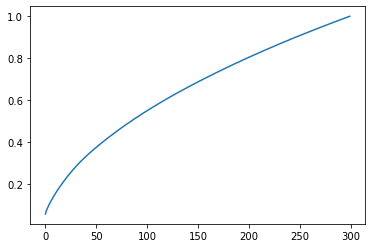

In [115]:
s = np.flipud(S1)
pov = np.cumsum(s**2) / np.sum(s**2)
plt.plot(pov)

In [106]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=100)
X_tr = pca.fit_transform(X)

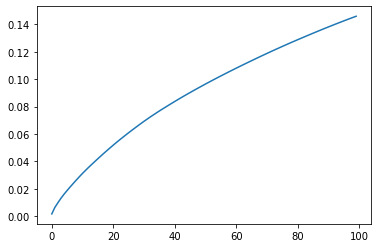

In [110]:
p = np.cumsum(pca.explained_variance_ratio_)
plt.plot(p)

In [72]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1,
                verbose=True)
km.fit(X_tr)

Initialization complete
Iteration 0, inertia 210.81517939508086
Iteration 1, inertia 174.7319485592479
Iteration 2, inertia 172.1255842873564
Iteration 3, inertia 170.9544371946473
Iteration 4, inertia 170.47439248151383
Iteration 5, inertia 170.19920016091964
Iteration 6, inertia 170.03584414279382
Iteration 7, inertia 169.9388364297175
Iteration 8, inertia 169.87629164183969
Iteration 9, inertia 169.8420998619317
Iteration 10, inertia 169.82513929958827
Iteration 11, inertia 169.81388007000578
Iteration 12, inertia 169.80926262653355
Converged at iteration 12: center shift 2.861467613817101e-07 within tolerance 3.139215698600419e-07


KMeans(max_iter=100, n_clusters=4, n_init=1, verbose=True)

In [81]:
V = pca.inverse_transform(km.cluster_centers_)
order_centroids = np.fliplr(np.argsort(V, axis=1))
if 1:
    for i in range(n_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Cluster 0: com article netcom stratus hp sun posting don nntp ibm
Cluster 1: university windows ca posting host nntp cs know like thanks
Cluster 2: people government key don just com article clipper think like
Cluster 3: god jesus people bible christian believe don christians say think


In [82]:
cnt = np.zeros((ncat,n_clusters), dtype=int)
for i, cat in enumerate(categories):
    print('%-40s ' % cat, end='')
    for j in range(n_clusters):
        cnt[i,j] = np.sum((labelkm==j) & (labels==i))
    cntp = cnt[i,:] / np.sum(cnt[i,:])
    for j in range(n_clusters):
        print('%5.3f ' % cntp[j], end='')
    print()

alt.atheism                              0.000 0.121 0.707 0.171 
comp.graphics                            0.000 0.883 0.004 0.113 
comp.os.ms-windows.misc                  0.000 0.886 0.004 0.110 
comp.sys.ibm.pc.hardware                 0.003 0.852 0.000 0.145 
comp.sys.mac.hardware                    0.000 0.916 0.001 0.083 
comp.windows.x                           0.000 0.858 0.001 0.141 
misc.forsale                             0.017 0.841 0.002 0.139 
rec.autos                                0.000 0.518 0.020 0.462 
rec.motorcycles                          0.001 0.425 0.012 0.562 
rec.sport.baseball                       0.658 0.192 0.005 0.145 
rec.sport.hockey                         0.893 0.067 0.002 0.038 
sci.crypt                                0.000 0.156 0.052 0.791 
sci.electronics                          0.012 0.753 0.000 0.235 
sci.med                                  0.084 0.531 0.070 0.315 
sci.space                                0.059 0.640 0.036 0.264 
soc.religi

## Comparison of clusters to newsgroup categories

The clusters found by k-means were not based on the newsgroup category in which the post came from.  To compare the two, we create a sort of confusion matrix where:

`C[i,j] = ` fraction of cluster `j` came from newsgroup `i`.

In [11]:
labelkm = km.labels_
from sklearn.metrics import confusion_matrix
C = confusion_matrix(labels,labelkm)

Csum = np.sum(C,axis=0)
Cnorm = C / Csum[None,:]
print(Cnorm)

[[0.0015873  0.07790627 0.55480984 0.79090909]
 [0.01269841 0.58673159 0.00111857 0.        ]
 [0.97936508 0.22337188 0.0033557  0.        ]
 [0.00634921 0.11199026 0.44071588 0.20909091]]


To interpret this confusion matrix, let's print out the newsgroup names:

In [12]:
dataset.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Now, returning to the confusion matrix, we see that some discovered clusters lie almost entirely within one of the newsgroup subjects.  This is especially true for `comp.graphics` and `sci.space`.  However, some discovered clusters tend to have entries of both `alt.atheism` and `talk.religon.misc`, whose topics are likely to have a lot of overlap.

We print an example of a post that came from a newsgroup that is different from the most common newsgroup in that cluster.

In [13]:
I = np.where((labels==3) & (labelkm == 3))[0]
doc_ind = I[3]
ind_cluster = labelkm[doc_ind]
km_cat = dataset.target_names[np.argmax(Cnorm[:,ind_cluster])]

data_ex = dataset.data[doc_ind]
true_cat  = dataset.target_names[labels[doc_ind]]
print('Actual newsgroup: {0:s}'.format(true_cat))
print('Most common newsgroup in cluster:  {0:s}'.format(km_cat))
print()
print(data_ex)

Actual newsgroup: talk.religion.misc
Most common newsgroup in cluster:  alt.atheism

From: nrp@st-andrews.ac.uk (Norman R. Paterson)
Subject: Re: After 2000 years, can we say that Christian Morality is
Organization: St. Andrews University, Scotland.
Lines: 16

In article <1r59na$e81@fido.asd.sgi.com> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
>In article <1993Apr21.141259.12012@st-andrews.ac.uk>, nrp@st-andrews.ac.uk (Norman R. Paterson) writes:
>|> In article <1r2m21$8mo@fido.asd.sgi.com> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
...
>> Ok, so you don't claim to have an absolute moral system.  Do you claim
>> to have an objective one?  I'll assume your answer is "yes," apologies
>> if not.
>
>I've just spent two solid months arguing that no such thing as an
>objective moral system exists.
>
>jon.

Apologies, I've not been paying attention.

-Norman



## Latent Semantic Analysis

Another important tool in document analysis is [latent semantic analysis (LSA)](https://en.wikipedia.org/wiki/Latent_semantic_analysis).  In LSA, we simply compute an SVD of the TF-IDF matrix,

    X = U diag(S) V
    
This is equivalent to performing a PCA on `X`.  If we let `A = U diag(S)` then `X = AV`.  First, we compute the PCs of `X`.  Since `X` is a sparse matrix, it is preferable to use the sparse `svds` method in the `scipy` package.

In [14]:
import scipy.sparse.linalg
U1,S1,V1 = scipy.sparse.linalg.svds(X,k=300)

We can next plot the singular values. We see that the first few singular values are significantly larger than the remaining singular values suggesting that the term-document matrix `X` has a low rank structure.

In [16]:
import matplotlib.pyplot as plt

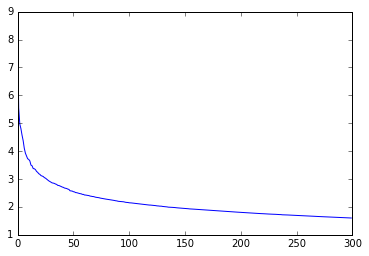

In [38]:
plt.plot(S1[::-1])

Given the low rank structure of `X`, we can write 

     X[n,i] = \sum_k A[n,k] V[k,i]
     
where the sum is over some relatively small number of components.  There are two uses for this representation:
* Word and document embeddings:  A[n,:] provides a low-dimensional vector representation of each document.  This is useful pre-processing step in many natural processing (NLP) methods.  This type of representation is closely related to an important topic of *word embeddings* and *document embeddings*.
* Topic modeling:  One interpretation of the PCA is that each PC `k` represents some common *topic* in the corpus.  Then, `A[n,k] =` the component of topic `k` in document `n` and `V[k,i]` represents the occurance of word `i` in topic `k`.

To get an idea of the words within each PC, we print the words for the largest components in the first 5 PCs.  On a small corpus like 20 newsgroups, the PCs in this case are not very useful.  But, the technique can yield more useful results in larger corpi.

In [41]:
V1sort = np.abs(V1).argsort()[:, ::-1]
for i in range(5):
    print("PC %d:" % i, end='')
    for ind in V1sort[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

PC 0: muenchen does dan bockamp targa colour shall ch uk man
PC 1: phigs government uci 3d khomeini colorado uni rh rayshade screen
PC 2: clarke asimov wesleyan values vga physics fl ed pluto tyre
PC 3: ericsson color wesleyan point program convenient boeing scott targa jpeg
PC 4: thanks muenchen format mac earth pluto color uci true ether


In [17]:
U1.shape

(3387, 300)

In [35]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=True)
km.fit(X_tr)

Initialization complete
Iteration 0, inertia 86.27353297947184
Iteration 1, inertia 53.17605492696268
Iteration 2, inertia 52.017132158220114
Iteration 3, inertia 51.32589878421361
Iteration 4, inertia 50.99974695298535
Iteration 5, inertia 50.85708605986888
Iteration 6, inertia 50.80220190835376
Iteration 7, inertia 50.758690599261435
Iteration 8, inertia 50.73585498021275
Iteration 9, inertia 50.71972442121352
Iteration 10, inertia 50.713337634106075
Iteration 11, inertia 50.71068661044915
Iteration 12, inertia 50.706919021802136
Iteration 13, inertia 50.70432669115986
Converged at iteration 13: center shift 2.474934615666404e-07 within tolerance 6.349559876836782e-07


KMeans(max_iter=100, n_clusters=4, n_init=1, verbose=True)

In [36]:
V_tr =  km.cluster_centers_
V_tr.shape
V = pca.inverse_transform(V_tr)

order_centroids = np.fliplr(np.argsort(V, axis=1))

In [37]:
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: henry space toronto access digex nasa zoo pat spencer alaska
Cluster 1: god com don people space graphics university know just like
Cluster 2: sandvik kent apple newton com alink ksand jesus net cookamunga
Cluster 3: sgi livesey keith wpd solntze jon caltech com morality moral
